# Quantum Kernel Method

In this notebook, we will implement examples for the quantum kernel method step-by-step.

## Step 1: Map classical inputs to a quantum problem

* Input: Training dataset
* Output: Abstract circuit for calculating a kernel matrix entry

In this step, data is mapped into the Hilbert state for which we need an encoding method. This is done either by constructing an own circuit or using a pre-made feature map like `zz_feature_map`.

## Step 2: Optimize problem for quantum execution

* Input: Abstract circuit, not optimized for a particular backend
* Output: Target circuit and observable, optimized for the selected QPU

The circuit optimization procedure tries to make the circuit compatible with real quantum computers or to simplify the calculation for simulations. Herefore, we use built-in Qiksit functions, in particular the `generate_preset_pass_manager`. The `optimization_level=3` ensures the highest level of optimization.

## Step 3: Execute using Qiskit Runtime Primitives

* Input: Target circuit
* Output: Probability distribution

The probability distribution can be obtained with Qiskit's `Sampler`, which gives back a quasi-probability distribution.

## Step 4: Post-process, return result in classical format

* Input: Probability distribution
* Output: A single kernel matrix element, or a kernel matrix if repeating

Calculate the probability of measuring $|0\rangle^{\otimes N}$ on the quantum circuit, and populate the kernel matrix in the position corresponding to the two data vectors used. To fill out the entire kernel matrix, we need to run a quantum experiment for each entry. After that, we can use a classical machine learning algorithm that accept pre-calculated kernels, e.g. `qml_svc = SVC(kernel="precomputed")`. Then use the classical workstreams to apply the model to test data, and get an accuracy score.


# Single kernel matrix entry

## Step 1: Map classical input to a quantum problem

Training dataset $\to$ Abstract circuit for calculating a kernel matrix entry

As an example, we use a data set with 10 features. First, look at 2 data points where we remove the labels (last entry). 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
# Two mock data points, including category labels, as in training
small_data = [
    [-0.194, 0.114, -0.006, 0.301, -0.359, -0.088, -0.156, 0.342, -0.016, 0.143, 1],
    [-0.1, 0.002, 0.244, 0.127, -0.064, -0.086, 0.072, 0.043, -0.053, 0.02, -1],
]
 
# Data points with labels removed, for inner product
train_data = [small_data[0][:-1], small_data[1][:-1]]

For the feature mapping (encoding), let's use the `z_feature_map`:

In [2]:
# from qiskit.circuit.library import zz_feature_map
# fm = zz_feature_map(feature_dimension=np.shape(train_data)[1], entanglement='linear', reps=1)
 
from qiskit.circuit.library import z_feature_map
 
fm = z_feature_map(feature_dimension=np.shape(train_data)[1])
 
 
unitary1 = fm.assign_parameters(train_data[0])
unitary2 = fm.assign_parameters(train_data[1])

circuit depth =  9


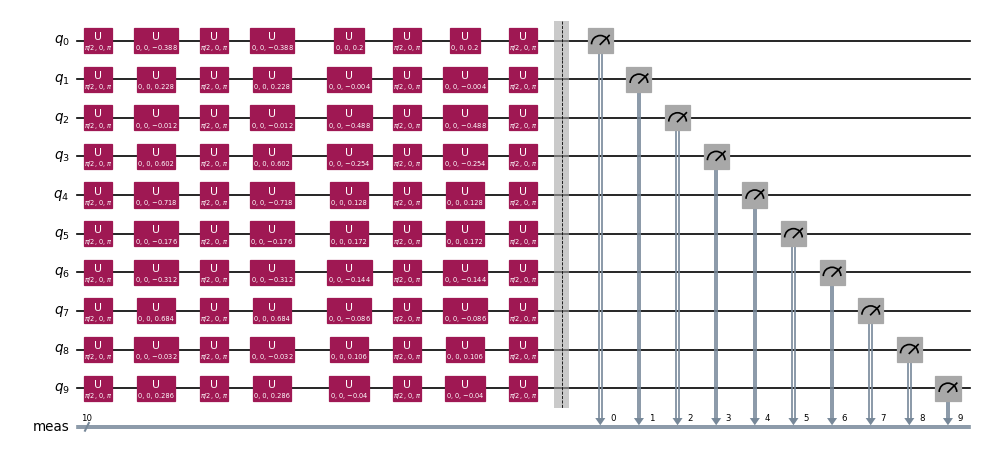

In [3]:
from qiskit.circuit.library import unitary_overlap
 
 
overlap_circ = unitary_overlap(unitary1, unitary2)
overlap_circ.measure_all()
 
print("circuit depth = ", overlap_circ.decompose().depth())
overlap_circ.decompose().draw("mpl", scale=0.6, style="iqp")

## Step 2: Optimize problem for quantum execution

Run it on least busy backend:

In [4]:
# Import needed packages
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

In [6]:
# Get the least busy backend
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=fm.num_qubits
)
print(backend)

management.get:WARNING:2026-02-04 16:47:38,237: Loading default saved account


<IBMBackend('ibm_fez')>


In [7]:
# Apply level 3 optimization to our overlap circuit
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
overlap_ibm = pm.run(overlap_circ)

In [8]:
print("circuit depth = ", overlap_ibm.decompose().depth())
overlap_ibm.decompose().depth(lambda instr: len(instr.qubits) > 1)

circuit depth =  10


1

## Step 3: Execute using Qiskit Runtime Primitives

Running on a simulator should only be used to debug scaled-down code (and simple code like this).

In [9]:
# Run this for a simulator
from qiskit.primitives import StatevectorSampler
 
from qiskit_ibm_runtime import Options, Session, Sampler
 
num_shots = 10000
 
# Evaluate the problem using state vector-based primitives from Qiskit
sampler = StatevectorSampler()
results = sampler.run([overlap_circ], shots=num_shots).result()
# .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
counts_bit = results[0].data.meas.get_counts()
# .get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
counts = results[0].data.meas.get_int_counts()

or

In [10]:
# Import our runtime primitive
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
num_shots = 10000
 
# Use sampler and get the counts
 
sampler = Sampler(mode=backend)
results = sampler.run([overlap_ibm], shots=num_shots).result()
# .get_counts() returns counts associated with a state labeled by bit results such as |001101...01>.
counts_bit = results[0].data.meas.get_counts()
# .get_int_counts returns the same counts, but labeled by integer equivalent of the above bit string.
counts = results[0].data.meas.get_int_counts()

## Step 4: Post-process, return result in classical format

The probability of measuring the zero state $|00000\rangle$ is then given by

In [11]:
counts.get(0, 0.0)/num_shots

0.6653

To look at the full distribution of measurement probabilities, we can use `plot_distribution` as

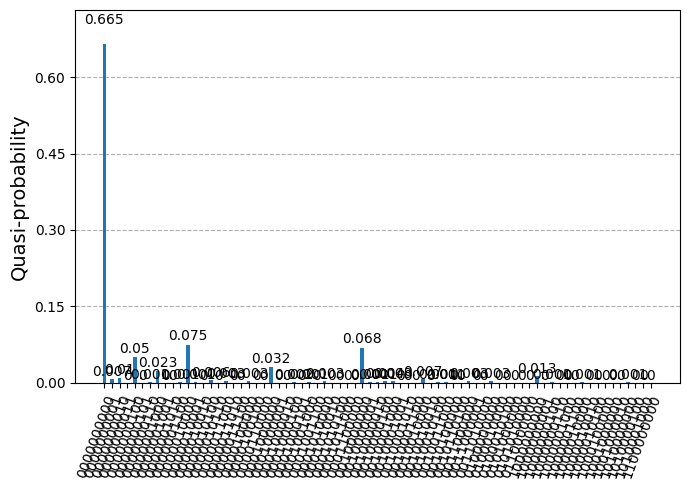

In [12]:
from qiskit.visualization import plot_distribution
 
plot_distribution(counts_bit)

This is not very clear, so let's define a function to pick only the top 10 most probable measurements:

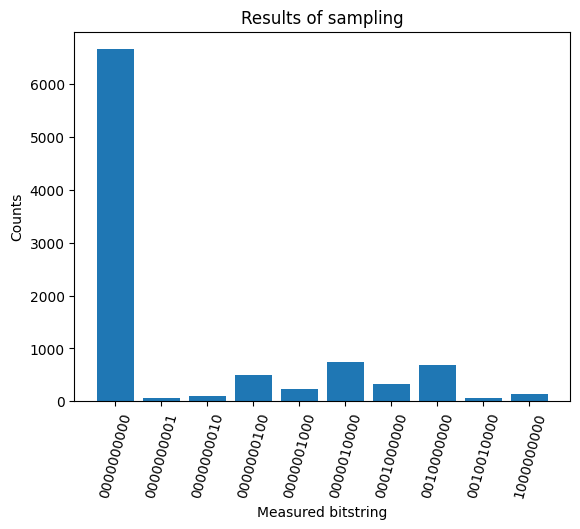

In [13]:
def visualize_counts(probs, num_qubits):
    """Visualize the outputs from the Qiskit Sampler primitive."""
    zero_prob = probs.get(0, 0.0)
    top_10 = dict(sorted(probs.items(), key=lambda item: item[1], reverse=True)[:10])
    top_10.update({0: zero_prob})
    by_key = dict(sorted(top_10.items(), key=lambda item: item[0]))
    xvals, yvals = list(zip(*by_key.items()))
    xvals = [bin(xval)[2:].zfill(num_qubits) for xval in xvals]
    plt.bar(xvals, yvals)
    plt.xticks(rotation=75)
    plt.title("Results of sampling")
    plt.xlabel("Measured bitstring")
    plt.ylabel("Counts")
    plt.show()
 
 
visualize_counts(counts, overlap_circ.num_qubits)

# Full kernel matrix